# Analysis of Exchange Rate Impact on Room Revenue

Author: Yap Zhi Ling
<br><br>
This project applies time series modelling, specifically Seasonal Autoregressive Integrated Moving Average (SARIMA) and Seasonal Autoregressive Integrated Moving Average with exogenous regressors (SARIMAX), to analyse and forecast hotel room revenue. Accurate forecasting of room revenue is critical for hotel management and sustainability. It enables financial planning of the business, and this methodology is broadly applicable to other industries and contexts. The workflow showcased here can be extended to scenarios where time series forecasting and impact assessment of external factors/drivers are valuable. 

For this project, exchange rate is an exogenous variable in room revenue modelling. This is grounded in the theory that currency fluctuations influence international travel demand and consequently, hotel perfomance and revenue. A weaker local currency typically makes hotels more affordable to foreign travelers, often leading to increased occupancy and potentially higher revenue. This project explores that theoretical concept.

## 1. Data Loading 
We begin by importing the necessary libraries and monthly room revenue and exchange rate datasets. The datasets will serve as the basis for our analysis and modeling. The datasets are loaded directly from CSV files.


### 1.1 Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import pmdarima as pm
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX

import warnings
warnings.filterwarnings('ignore')


### 1.2 Load Data

In [2]:
room_revenue = pd.read_csv('room_revenue(monthly).csv')
xchange_rate = pd.read_csv('exchange_rate(monthy).csv')

### 1.3 Initial Data Inspection

In [3]:
data_series_row = room_revenue[room_revenue['Unnamed: 0'] == 'Data Series'].iloc[0, 1:].values
room_revenue_row = room_revenue[room_revenue['Unnamed: 0'] == 'Room Revenue (Thousand Dollars)'].iloc[0, 1:].values

room_rev_df = pd.DataFrame([room_revenue_row], columns=data_series_row)
display(room_rev_df)


data_series_row = xchange_rate[xchange_rate['Unnamed: 0'] == 'Data Series'].iloc[0, 1:].values
xchange_rate_row = xchange_rate[xchange_rate['Unnamed: 0'] == 'US Dollar (Singapore Dollar Per US Dollar)'].iloc[0, 1:].values

xchange_rate_df = pd.DataFrame([xchange_rate_row], columns=data_series_row)
display(xchange_rate_df)


,2025 May,2025 Apr,2025 Mar,2025 Feb,2025 Jan,2024 Dec,2024 Nov,2024 Oct,2024 Sep,2024 Aug,...,2008 Oct,2008 Sep,2008 Aug,2008 Jul,2008 Jun,2008 May,2008 Apr,2008 Mar,2008 Feb,2008 Jan
0,431594.9,409740.5,414240.3,420973.5,449978.8,416799.2,425133,437944,507620.9,484395,...,178412,194819.3,166743,180123.9,177628.7,180126.8,184276.3,187570.5,171955.1,176098.3


,2025 Jun,2025 May,2025 Apr,2025 Mar,2025 Feb,2025 Jan,2024 Dec,2024 Nov,2024 Oct,2024 Sep,...,2008 Oct,2008 Sep,2008 Aug,2008 Jul,2008 Jun,2008 May,2008 Apr,2008 Mar,2008 Feb,2008 Jan
0,1.2843,1.2938,1.3246,1.3362,1.3469,1.3625,1.3503,1.3365,1.309,1.2964,...,1.4763,1.4287,1.4029,1.3588,1.3676,1.3665,1.3644,1.3855,1.4108,1.4315


In [4]:
room_rev_df.columns = pd.to_datetime(room_rev_df.columns, format = "%Y %b ")
xchange_rate_df.columns = pd.to_datetime(xchange_rate_df.columns, format="%Y %b ")
merged = pd.concat([room_rev_df,xchange_rate_df],ignore_index = True)
merged.index = ['Room Revenue (Thousand Dollars)', 'US Dollar (Singapore Dollar Per US Dollar)']

merged = merged.T
display(merged)
display(merged.dtypes)
merged['Room Revenue (Thousand Dollars)'] = pd.to_numeric(merged['Room Revenue (Thousand Dollars)'], errors='coerce')
merged['US Dollar (Singapore Dollar Per US Dollar)'] = pd.to_numeric(merged['US Dollar (Singapore Dollar Per US Dollar)'], errors='coerce')
clean_merged = merged.dropna()
display(clean_merged)
display(clean_merged.dtypes)

,Room Revenue (Thousand Dollars),US Dollar (Singapore Dollar Per US Dollar)
2008-01-01,176098.3,1.4315
2008-02-01,171955.1,1.4108
2008-03-01,187570.5,1.3855
2008-04-01,184276.3,1.3644
2008-05-01,180126.8,1.3665
...,...,...
2025-02-01,420973.5,1.3469
2025-03-01,414240.3,1.3362
2025-04-01,409740.5,1.3246
2025-05-01,431594.9,1.2938


Room Revenue (Thousand Dollars)               object
US Dollar (Singapore Dollar Per US Dollar)    object
dtype: object

,Room Revenue (Thousand Dollars),US Dollar (Singapore Dollar Per US Dollar)
2008-01-01,176098.3,1.4315
2008-02-01,171955.1,1.4108
2008-03-01,187570.5,1.3855
2008-04-01,184276.3,1.3644
2008-05-01,180126.8,1.3665
...,...,...
2025-01-01,449978.8,1.3625
2025-02-01,420973.5,1.3469
2025-03-01,414240.3,1.3362
2025-04-01,409740.5,1.3246


Room Revenue (Thousand Dollars)               float64
US Dollar (Singapore Dollar Per US Dollar)    float64
dtype: object

'2025-06-01' data has been dropped since room revenue for that month is missing.

## 2. Exploratory Data Analysis
### 2.1 Time Series Visualisation

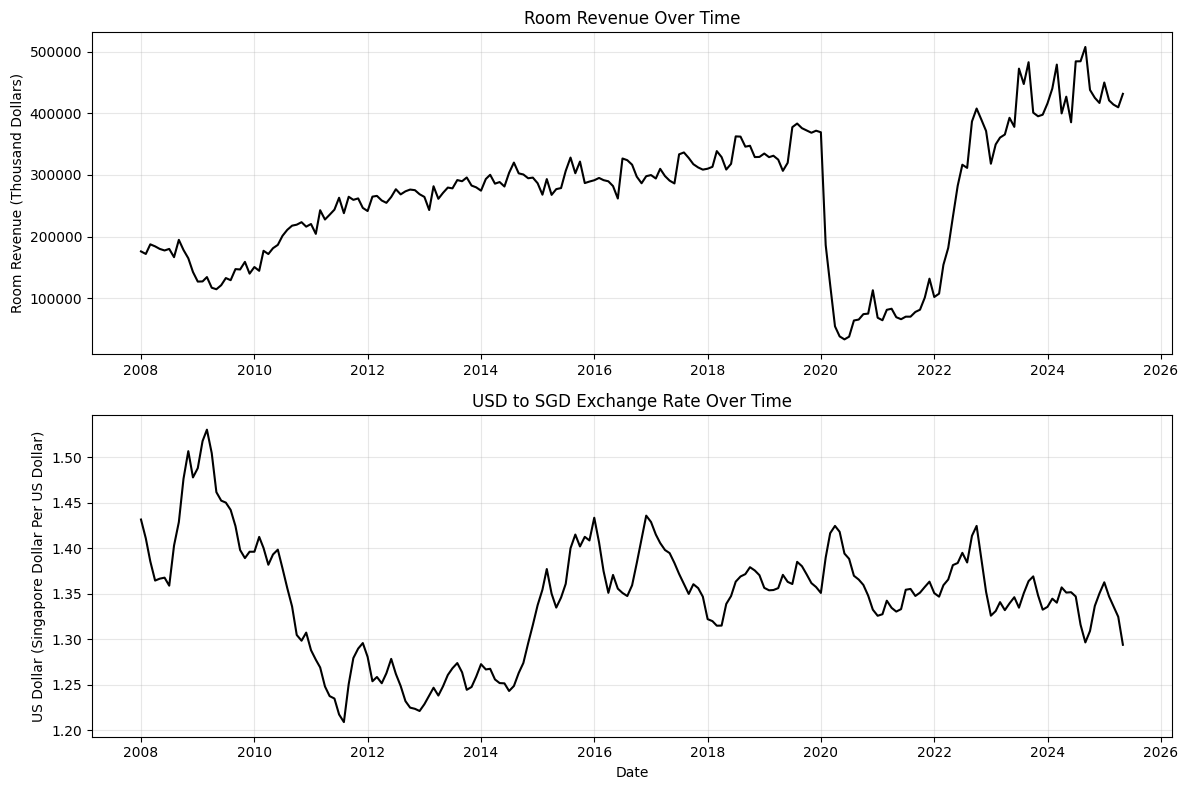

In [5]:
def plot_timeseries (df, col1, col2, title1, title2):
    fig, axes = plt.subplots(2, 1, figsize=(12, 8))

    # Plot Room Revenue (first column)
    axes[0].plot(df.index, df[col1], color='black', linewidth=1.5)
    axes[0].set_title(title1)
    axes[0].set_ylabel(col1)
    axes[0].grid(True, alpha=0.3)

    # Plot Exchange Rate (second column)
    axes[1].plot(df.index, df[col2], color='black', linewidth=1.5)
    axes[1].set_title(title2)
    axes[1].set_ylabel(col2)
    axes[1].set_xlabel('Date')
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

plot_timeseries(df=clean_merged, col1='Room Revenue (Thousand Dollars)', col2='US Dollar (Singapore Dollar Per US Dollar)' ,
                 title1='Room Revenue Over Time', title2='USD to SGD Exchange Rate Over Time')

The analysis begins by visualising monthly room revenue and exchange rate over the period to identify trends or any unusual patterns. From the room revenue line plot, there is a significant drop from the year 2020 to around year 2023. 

### 2.2 Identify Lag

[-0.2273891189095937,
 -0.22949423775322675,
 -0.23342890387132137,
 -0.23635071993800352,
 -0.23707140821273323,
 -0.23896782990962187,
 -0.24155575969796667,
 -0.23785134050176251,
 -0.23089935028084557,
 -0.2196194619046917,
 -0.2121922088866754,
 -0.2101609447993042,
 -0.20956499025380265]

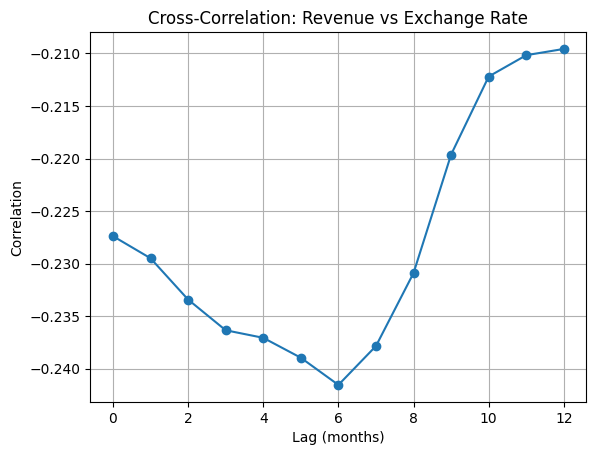

In [6]:

def find_lag (df, lag_range, col1, col2, title, x_label):
    correlations = []
    lags = range(0, lag_range)
    for lag in lags:
        if lag == 0:
            corr = df[col1].corr(df[col2])
        else:
            corr = df[col1].corr(df[col2].shift(lag))
        correlations.append(corr)

    plt.plot(lags, correlations, marker='o')
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel('Correlation')
    plt.grid(True)

    return correlations

find_lag(df=clean_merged, lag_range=13, col1='Room Revenue (Thousand Dollars)', 
         col2='US Dollar (Singapore Dollar Per US Dollar)', title='Cross-Correlation: Revenue vs Exchange Rate', x_label='Lag (months)')
        


To explore temporal dependencies between revenue and exchange rates, cross-correlation is used to identify significant lags. It can reveal the delayed effects of exchange rate changes on room revenue.
<br> <br>
From our cross-correlation plot, 6 months lag shows the strongest relationship. This suggests that the effects of exchange rate may influence room revenue around 6 months later. 
<br><br>
However, do note that the negative correlation (approximately -0,24) means that when exchange rate increases (i.e., Singapore Dollar weakens against United States Dollar), room revenue tends to be lower about 6 months later. The negative correlation can imply that currency strength has an inverse effect on demand.
<br><br>
Do keep in mind that the correlation does not imply causation (there might be external events), the data has not been adjusted for stationarity (part of the correlation could be due to shared trends or seasonality), and that the relatively low magnitude means the effect is not highly predictive. 

### 2.3 Seasonal Decomposition

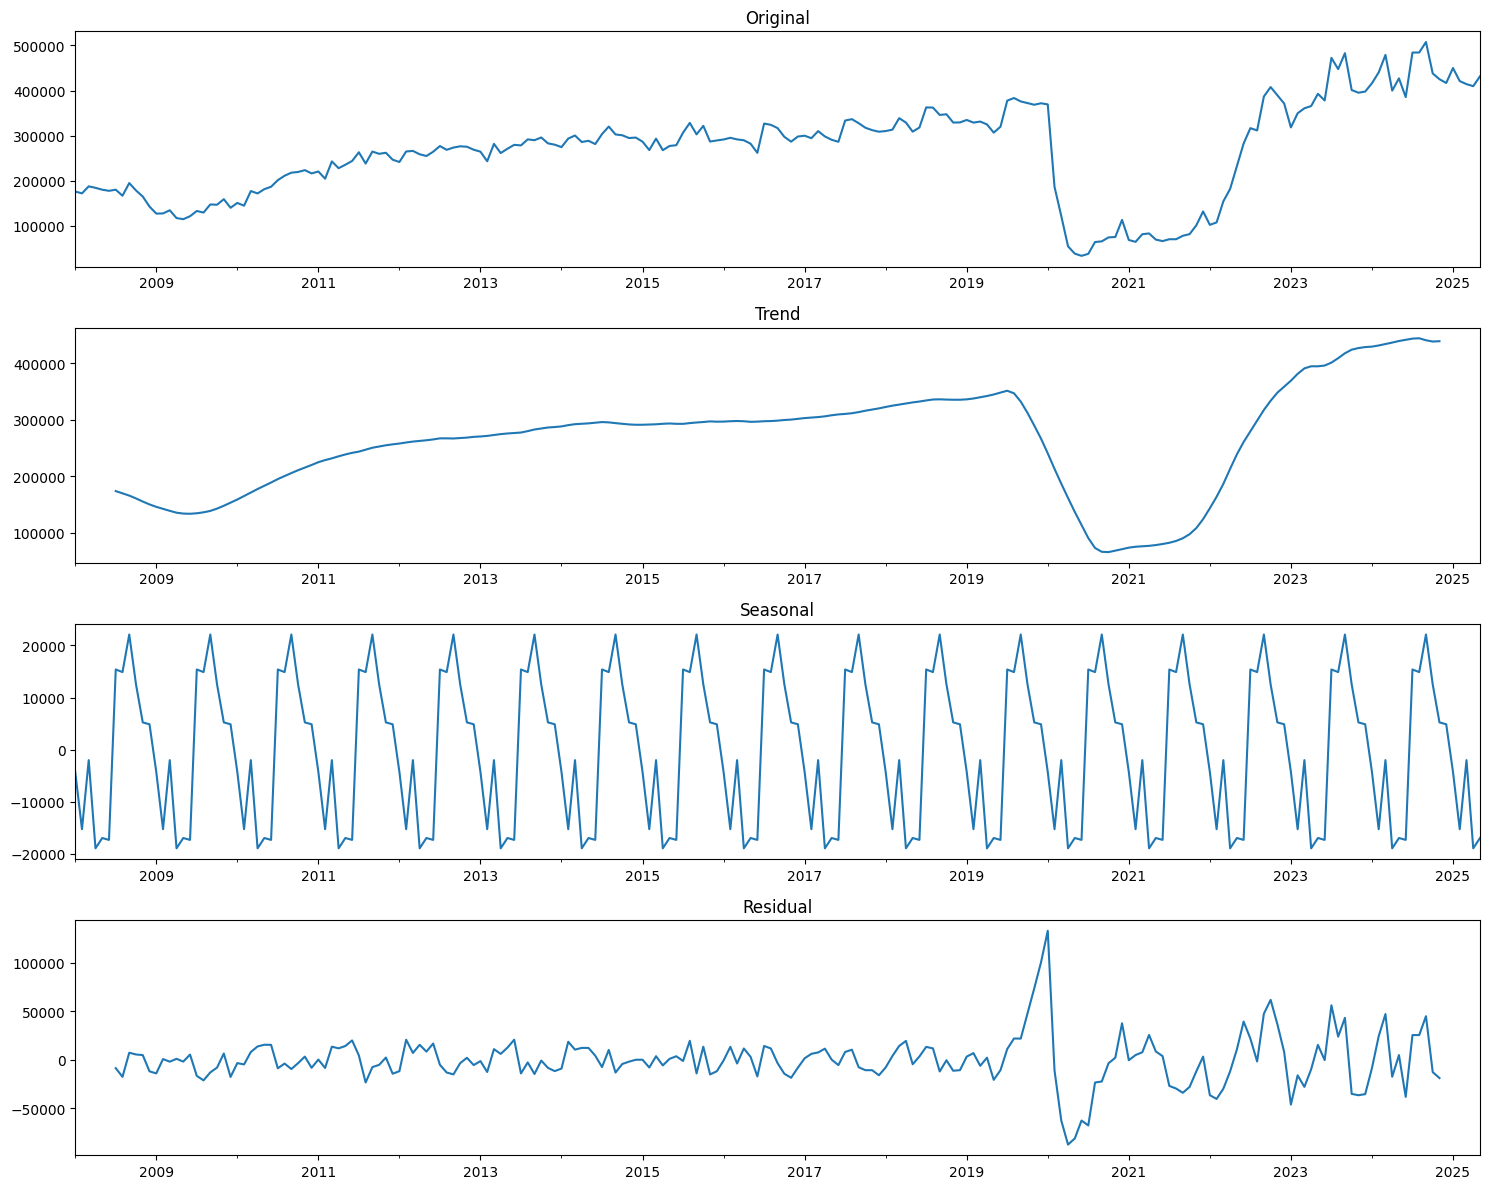

In [7]:
def seasonal_decomposition(df, col):
    
    # Perform decomposition
    decomposition = seasonal_decompose(df[col], model='additive', period=12)
    
    # Plot decomposition
    fig, axes = plt.subplots(4, 1, figsize=(15, 12))
    
    decomposition.observed.plot(ax=axes[0], title='Original')
    decomposition.trend.plot(ax=axes[1], title='Trend')
    decomposition.seasonal.plot(ax=axes[2], title='Seasonal')
    decomposition.resid.plot(ax=axes[3], title='Residual')
    
    plt.tight_layout()
    plt.show()
    
    return decomposition

seasonal_decomposition(df=clean_merged, col='Room Revenue (Thousand Dollars)')

Seasonal decomposition breaks down the time series into trend, seasonal, and residual components. This gives insights into the underlying seasonal patterns and overall trends driving the data.
<br> <br>
From the trend plot, there is a large dip in room revenue from around 2020 to the start of 2021. This is probably due to COVID-19 and restrictions on travelling which negatively impacted the tourism sector.

## 3. Stationarity Testing
<br><br>
SARIMA and SARIMAX models like many time series models assume stationarity. A stationary time series has constant mean, variance and autocovariance over time, which allow for reliable modeling and forecasting. 
<br><br>
### 3.1 ADF & KPSS Testing

In [8]:
def test_stationarity(df, col):

    # ADF Test
    adf_result = adfuller(df[col])
    print("ADF Test Results:")
    print(f"  ADF Statistic: {adf_result[0]:.3f}")
    print(f"  p-value: {adf_result[1]:.3f}")
    print(f"  Critical Values:")
    for key, value in adf_result[4].items():
        print(f"    {key}: {value:.3f}")
    
    if adf_result[1] <= 0.05:
        print("  Result: Series (",col,") is stationary (reject null hypothesis)")
    else:
        print("  Result: Series (",col,") is non-stationary (fail to reject null hypothesis)")
    
    # KPSS Test
    kpss_result = kpss(df[col])
    print("\nKPSS Test Results:")
    print(f"  KPSS Statistic: {kpss_result[0]:.3f}")
    print(f"  p-value: {kpss_result[1]:.3f}")
    print(f"  Critical Values:")
    for key, value in kpss_result[3].items():
        print(f"    {key}: {value:.3f}")
    
    if kpss_result[1] <= 0.05:
        print("  Result: Series (",col,") is non-stationary (reject null hypothesis)")
    else:
        print("  Result: Series (",col,") is stationary (fail to reject null hypothesis)")
    
    print()
    
    return adf_result, kpss_result

test_stationarity(df=clean_merged, col='Room Revenue (Thousand Dollars)')
test_stationarity(df=clean_merged, col='US Dollar (Singapore Dollar Per US Dollar)')

ADF Test Results:
  ADF Statistic: -2.869
  p-value: 0.049
  Critical Values:
    1%: -3.464
    5%: -2.876
    10%: -2.575
  Result: Series ( Room Revenue (Thousand Dollars) ) is stationary (reject null hypothesis)

KPSS Test Results:
  KPSS Statistic: 0.449
  p-value: 0.056
  Critical Values:
    10%: 0.347
    5%: 0.463
    2.5%: 0.574
    1%: 0.739
  Result: Series ( Room Revenue (Thousand Dollars) ) is stationary (fail to reject null hypothesis)

ADF Test Results:
  ADF Statistic: -2.412
  p-value: 0.138
  Critical Values:
    1%: -3.462
    5%: -2.876
    10%: -2.574
  Result: Series ( US Dollar (Singapore Dollar Per US Dollar) ) is non-stationary (fail to reject null hypothesis)

KPSS Test Results:
  KPSS Statistic: 0.193
  p-value: 0.100
  Critical Values:
    10%: 0.347
    5%: 0.463
    2.5%: 0.574
    1%: 0.739
  Result: Series ( US Dollar (Singapore Dollar Per US Dollar) ) is stationary (fail to reject null hypothesis)



((-2.4121268754511354,
  0.1383429003542398,
  2,
  206,
  {'1%': -3.4624988216864776,
   '5%': -2.8756749365852587,
   '10%': -2.5743041549627677},
  -1099.93755901857),
 (0.19339000019633878,
  0.1,
  9,
  {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}))

The Augmented Dickey-Fuller (ADF) test is used to detect the presence of a unit root in the time series, where the null hypothesis: series has a unit root (i.e., non-stationary), alternative hypothesis: series is stationary. If p-value is less than 0.05, we can reject the null hypothesis and conclude that the series is stationary.
<br><br>
The Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test complements ADF but has the opposite hypotheses. If the p-value is less than 0.05, we reject null hypothesis and conclude that the series is non-stationary.
<br><br>
From the ADF and KPSS tests, room revenue is stationary while exchange rate is non-stationary due to its contradicting conclusions from the tests. 

### 3.2 Plotting ACF & PACF

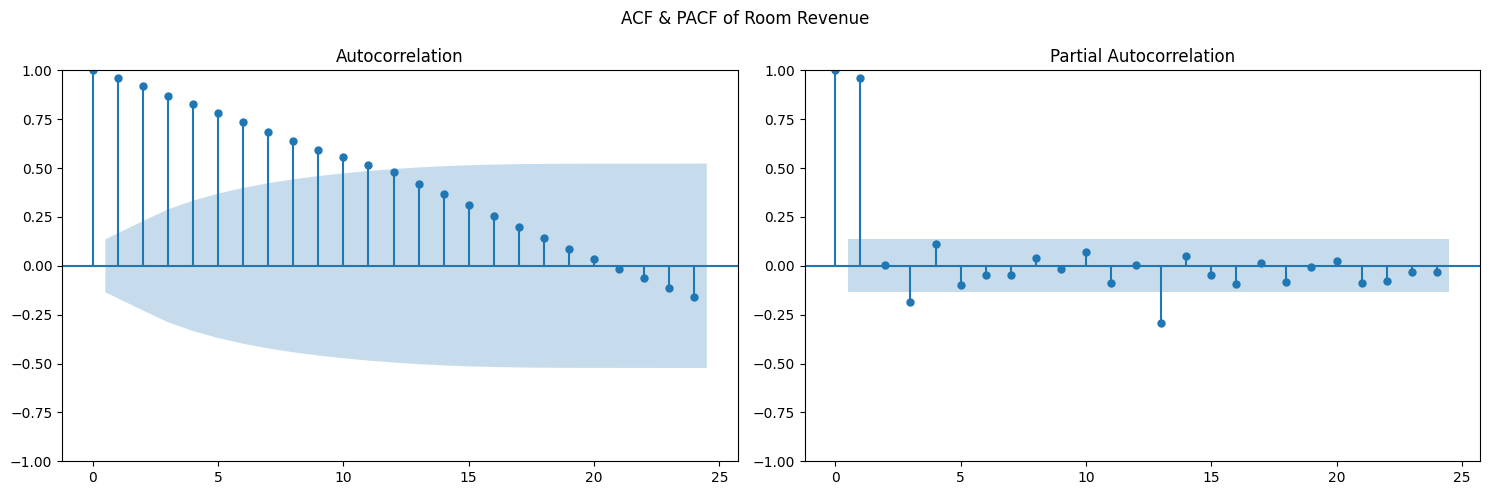

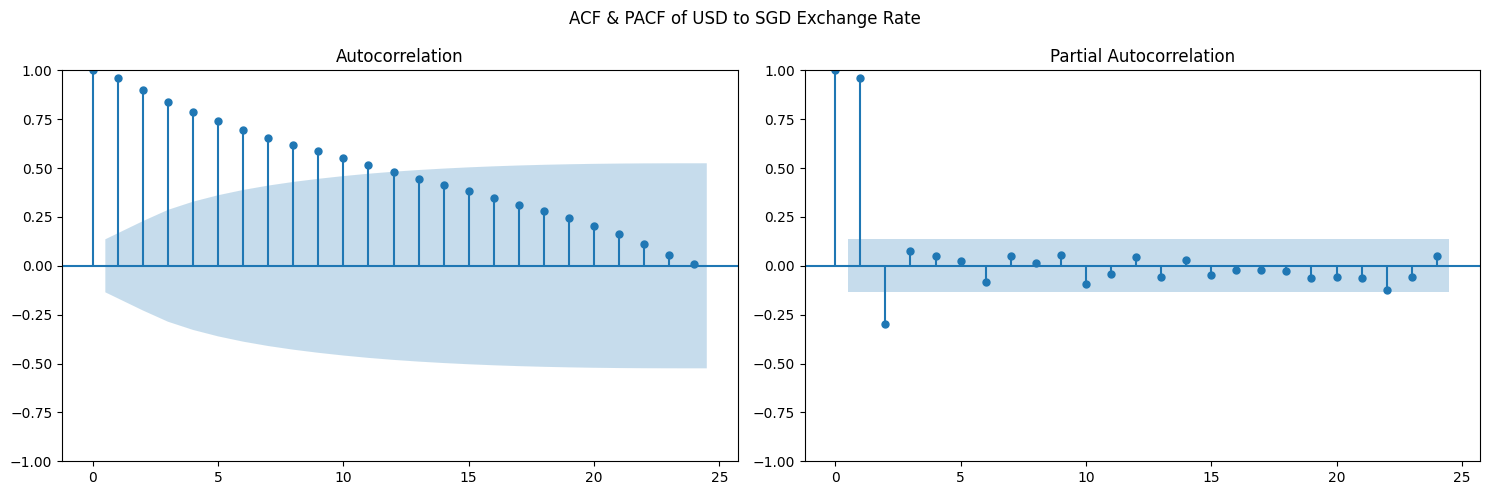

In [9]:
def acf_pacf(series,title, lags=24):

    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    plot_acf(series.dropna(), ax=axes[0], lags=lags)
    plot_pacf(series.dropna(), ax=axes[1], lags=lags)
    fig.suptitle(title)
    plt.tight_layout()
    plt.show()

acf_pacf(series=clean_merged['Room Revenue (Thousand Dollars)'], title='ACF & PACF of Room Revenue')
acf_pacf(series=clean_merged['US Dollar (Singapore Dollar Per US Dollar)'], title='ACF & PACF of USD to SGD Exchange Rate' )

Visualising Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) plots helps assess the dependency structure and stationarity. A slowly decaying ACF suggests non-stationarity while, a stationary series usually shows a quick drop in autocorrelation values. 
<br><br>
From the plots, both room revenue and exchange rate are non-stationary due to its downward sloping ACF. Despite the ADF and KPSS tests showing that room revenue is stationary, the ACF and PACF plots shows otherwise. 
<br><br>
For room revenue, the statistical tests and visual plots disagree on stationarity. It is possible that room revenue is trend-stationary (stationary around a trend) which can satisfy ADF and KPSS tests but will be problematic for SARIMA and SARIMAX models. In conclusion, there is a strong likelihood that room revenue is non-stationary.

## 4. Data Preprocessing
<br><br>
Since data on room revenues and exchange rates are non-stationary, differencing is required. COVID-19 affected the data significantly and there is a 6 months lag to account for.
<br><br>
### 4.1 Differencing 

In [10]:
def differencing(df, col):
    diff1 = df[col].diff().dropna()
    
    adf_result = adfuller(diff1)
    
    if adf_result[1] <= 0.05:
        print("Series is stationary after first differencing")
        return diff1
    else:
        diff2 = diff1.diff().dropna()
        adf_result_2 = adfuller(diff2)
        
        if adf_result_2[1] <= 0.05:
            print("Series is stationary after second differencing")
            return diff2
        else:
            print("Series still not stationary")
            return diff2
        
differenced_xchange = differencing(df=clean_merged, col='US Dollar (Singapore Dollar Per US Dollar)')
differenced_revenue = differencing(df=clean_merged, col='Room Revenue (Thousand Dollars)')

Series is stationary after first differencing
Series is stationary after first differencing


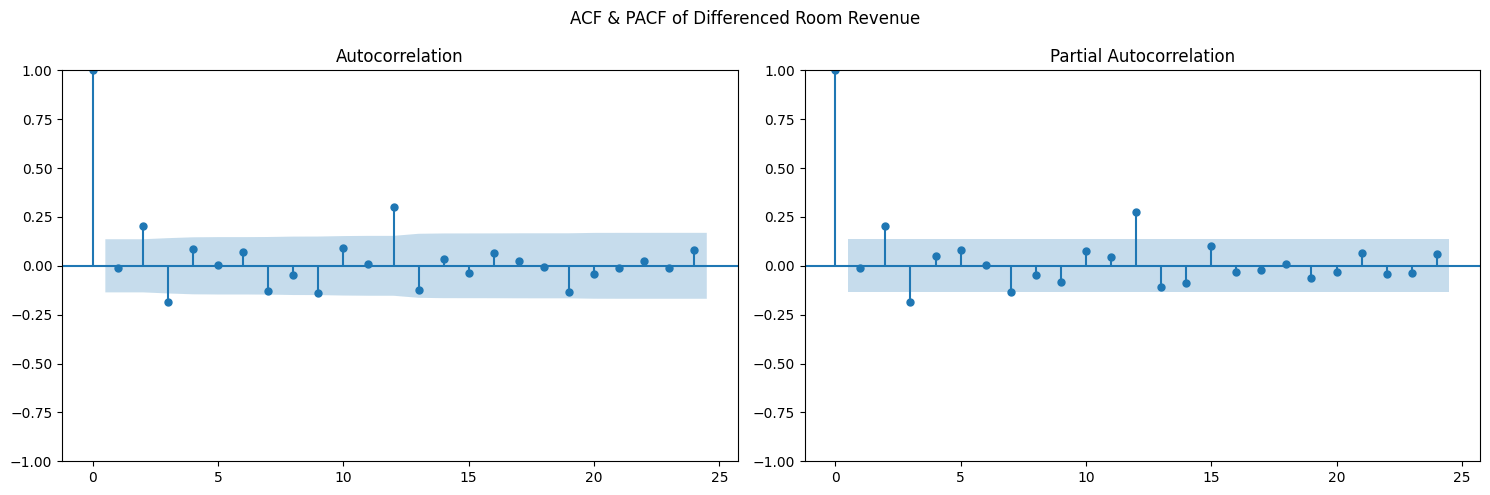

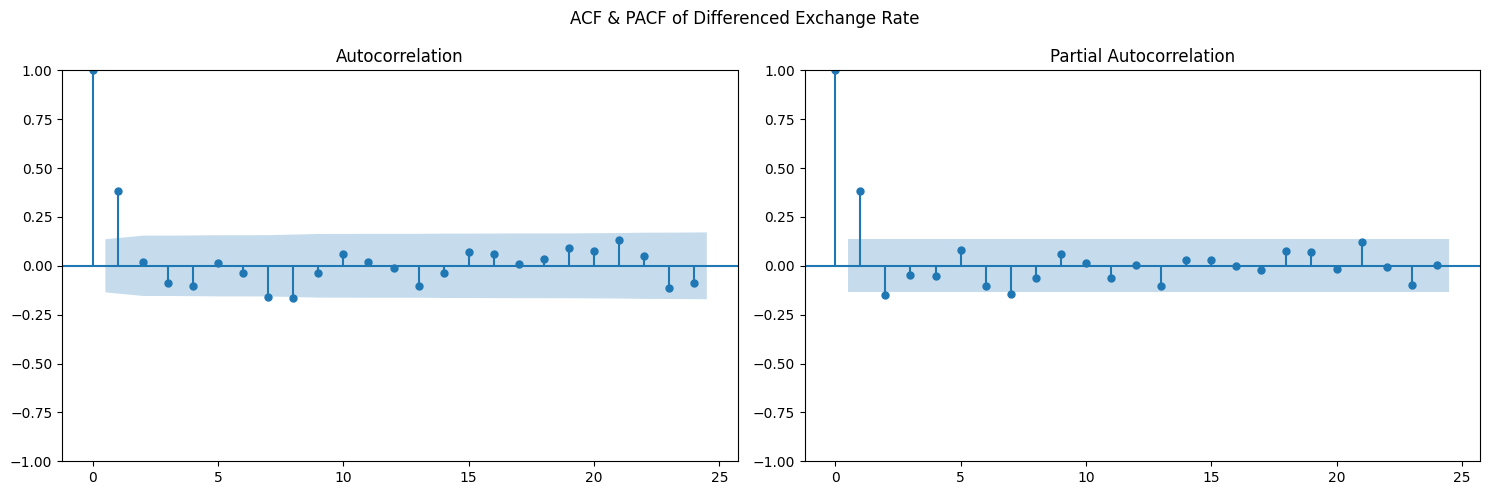

In [11]:
acf_pacf(series=differenced_revenue, title='ACF & PACF of Differenced Room Revenue')
acf_pacf(series=differenced_xchange, title='ACF & PACF of Differenced Exchange Rate')

First-order differencing is used to remove non-seasonal trends, making the data stationary which is shown in the new ACF & PACF plots for both room revenue and exchange rate.

### 4.2 Adding lag and COVID mask

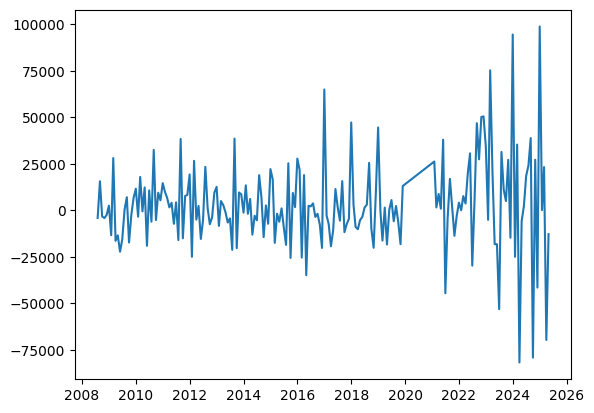

In [12]:
differenced_revenue_lag6 = differenced_revenue.shift(6)
covid_mask = ~((differenced_revenue_lag6.index >= '2020-01') & (differenced_revenue_lag6.index <= '2021-01'))
differenced_revenue_lag6 = differenced_revenue_lag6[covid_mask]
plt.plot(differenced_revenue_lag6)

The previous cross-correlation analysis indicated a 6 months lag. Shifting the room revenue data by 6 data points accounts for the delayed effect, allowing SARIMA and SARIMAX model to appropriately test whether past exchange rate changes can explain variations in current room revenue. 
<br><br>
From seasonal decomposition analysis, there is a possible disruption in the room revenue data due to COVID-19 pandemic. A binary mask variable is added to account for the non-recurring fluctuations seen, helping our model perform more accurately in capturing normal business conditions.

## 5. Model Development
### 5.1 Train/Test Split

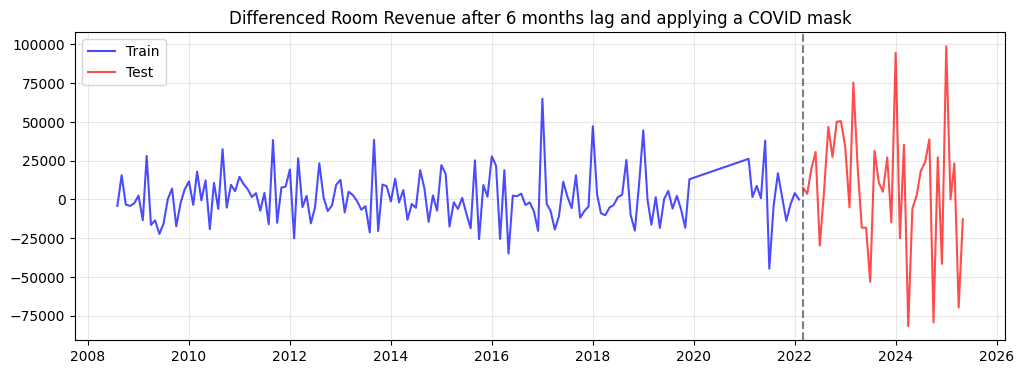

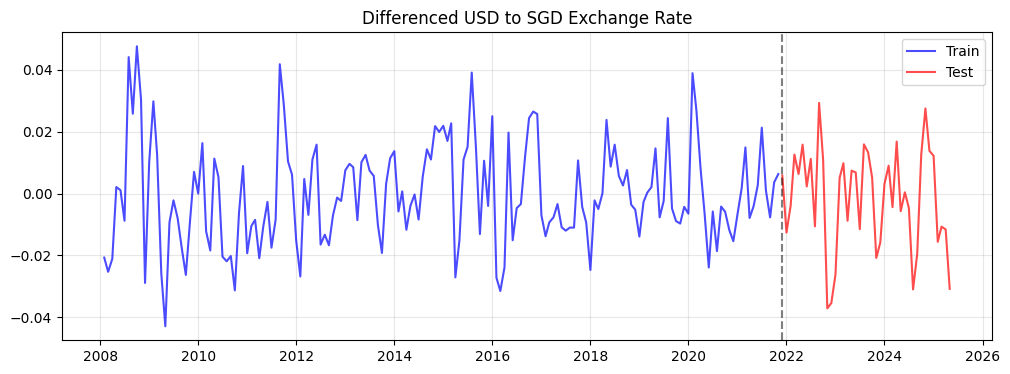

In [13]:
def train_test_split(series, train_ratio=0.8):
    split_point = int(len(series) * train_ratio)
    train = series.iloc[:split_point]
    test = series.iloc[split_point:]
    return train, test

def plot_split(train_series, test_series, title=""):
    plt.figure(figsize=(12, 4))
    plt.plot(train_series.index, train_series, 'b-', label='Train', alpha=0.7)
    plt.plot(test_series.index, test_series, 'r-', label='Test', alpha=0.7)
    plt.axvline(test_series.index[0], color='black', linestyle='--', alpha=0.5)
    plt.title(title)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

train_revenue , test_revenue = train_test_split(series=differenced_revenue_lag6)
train_xchange, test_xchange = train_test_split(series=differenced_xchange)
plot_split (train_series=train_revenue, test_series=test_revenue, title="Differenced Room Revenue after 6 months lag and applying a COVID mask")
plot_split (train_series=train_xchange, test_series=test_xchange, title="Differenced USD to SGD Exchange Rate")

Before modeling, the data is split into a training set to build and tune the models, and a test set is reserved for evaluating forecast performance.

### 5.2 SARIMA Model Selection

In [14]:
def find_best_sarima_model(train_series, seasonal_period = 12):
    
    sarima_model = auto_arima(
        train_series,
        start_p=1, max_p=3,
        start_q=1, max_q=3,
        seasonal=True, m=12,
        start_P=0, max_P=2,
        start_Q=0, max_Q=2,
        d=0, D=0,  # Differencing
        stepwise=True,
        suppress_warnings=True,
        trace=True,
        error_action='ignore',
        random_state=42
    )
    
    print(f"\nBest SARIMA model: {sarima_model.order} x {sarima_model.seasonal_order}")
    print(f"AIC: {sarima_model.aic():.4f}")
    
    return sarima_model

sarima_model = find_best_sarima_model(train_series=train_revenue)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=3322.396, Time=0.10 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=3332.494, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=3292.990, Time=0.09 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=3303.983, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=3331.423, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=3323.803, Time=0.01 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=3284.300, Time=0.28 sec
 ARIMA(1,0,0)(2,0,1)[12] intercept   : AIC=3285.551, Time=0.26 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=3290.251, Time=0.09 sec
 ARIMA(0,0,0)(2,0,0)[12] intercept   : AIC=3299.582, Time=0.22 sec
 ARIMA(2,0,0)(2,0,0)[12] intercept   : AIC=3285.138, Time=0.35 sec
 ARIMA(1,0,1)(2,0,0)[12] intercept   : AIC=3286.103, Time=0.21 sec
 ARIMA(0,0,1)(2,0,0)[12] intercept   : AIC=3286.261, Time=0.13 sec
 ARIMA(2,0,1)(2,0,0)[12] intercept   : AIC=3284.499, Time=0.48 sec
 ARIMA(1,0,0)(2,0,0

SARIMA model development involves identifying the best combination of parameters that capture the autoregressive, differencing, and moving average components at both seasonal and non-seasonal levels. 
<br><br>
Auto_arima automates the parameter selection and searches across a range, evaluating models based on Akaike Information Criterion (AIC). The most preferred model has the lowest AIC.

### 5.3 SARIMAX Model Selection

In [15]:
def find_best_sarimax_model(train_y, train_exog, seasonal_period=12):
    
    sarimax_model = auto_arima(
        train_y,
        exogenous=train_xchange.values.reshape(-1, 1),
        start_p=1, max_p=3,
        start_q=1, max_q=3,
        seasonal=True, m=12,
        start_P=0, max_P=2,
        start_Q=0, max_Q=2,
        d=0, D=0,
        stepwise=True,
        suppress_warnings=True,
        trace=True,
        error_action='ignore',
        random_state=42
)
    print(f"\nBest SARIMAX model: {sarimax_model.order} x {sarimax_model.seasonal_order}")
    print(f"AIC: {sarimax_model.aic():.4f}")
    
    return sarimax_model

sarimax_model = find_best_sarimax_model(train_y=train_revenue, train_exog=train_xchange)


Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=3322.396, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=3332.494, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=3292.990, Time=0.12 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=3303.983, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=3331.423, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=3323.803, Time=0.01 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=3284.300, Time=0.25 sec
 ARIMA(1,0,0)(2,0,1)[12] intercept   : AIC=3285.551, Time=0.31 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=3290.251, Time=0.12 sec
 ARIMA(0,0,0)(2,0,0)[12] intercept   : AIC=3299.582, Time=0.26 sec
 ARIMA(2,0,0)(2,0,0)[12] intercept   : AIC=3285.138, Time=0.45 sec
 ARIMA(1,0,1)(2,0,0)[12] intercept   : AIC=3286.103, Time=0.21 sec
 ARIMA(0,0,1)(2,0,0)[12] intercept   : AIC=3286.261, Time=0.14 sec
 ARIMA(2,0,1)(2,0,0)[12] intercept   : AIC=3284.499, Time=0.54 sec
 ARIMA(1,0,0)(2,0,0

SARIMAX is similar to SARIMA but includes exogenous variable (6-month lagged exchange rate) to potentially improve the forecasts by capturing external drivers. 
<br><br>
The best SARIMAX model chosen is the same as the best SARIMA model chosen, with the same AIC. 
<br>This could be due:
* Exogenous variable contributing no additional explanatory power. 
<br>Data on exchange rates do not significantly improve the model's ability to explain variation in room revenue.
* Low Signal-to-Noise Ratio in exogenous variable. 
<br>The external variable, exchange rate, might be too weakly correlated to the target, room revenue, which cause the exogenous variable's coefficient to be near 0. The SARIMAX model behave like a SARIMA model. 

### 5.4 SARIMA & SARIMAX model after Log Transformation

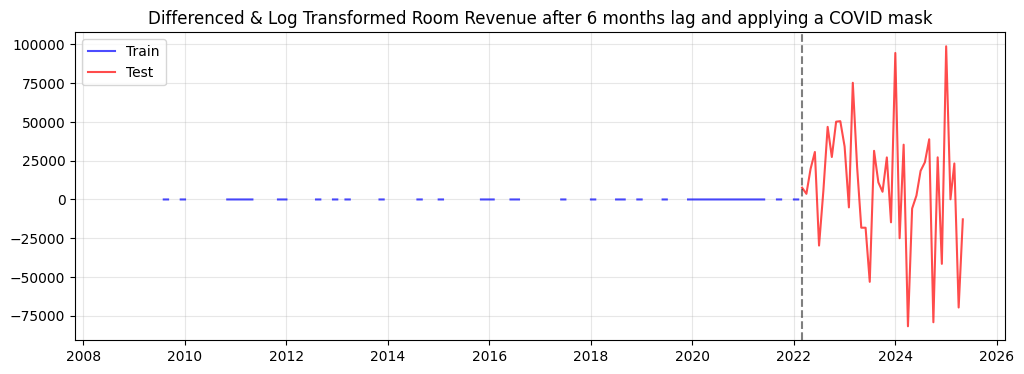

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=275.190, Time=0.17 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=272.273, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=273.889, Time=0.42 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=274.165, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=550.393, Time=0.01 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : AIC=272.135, Time=0.18 sec
 ARIMA(0,0,0)(2,0,0)[12] intercept   : AIC=274.135, Time=0.55 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=274.135, Time=0.34 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=272.352, Time=0.05 sec
 ARIMA(0,0,0)(2,0,1)[12] intercept   : AIC=276.130, Time=0.70 sec
 ARIMA(0,0,1)(1,0,0)[12] intercept   : AIC=273.925, Time=0.35 sec
 ARIMA(1,0,1)(1,0,0)[12] intercept   : AIC=275.023, Time=0.46 sec
 ARIMA(0,0,0)(1,0,0)[12]             : AIC=inf, Time=0.04 sec

Best model:  ARIMA(0,0,0)(1,0,0)[12] intercept
Total fit time: 3.358 seconds

Best SARIMA model: (0, 0

In [16]:
train_revenue_log = np.log(train_revenue)
plot_split (train_series=train_revenue_log, test_series=test_revenue, title="Differenced & Log Transformed Room Revenue after 6 months lag and applying a COVID mask")
sarima_model_log = find_best_sarima_model(train_series=train_revenue_log)
print(sarima_model_log.summary())
sarimax_model_log = find_best_sarimax_model(train_y=train_revenue_log, train_exog=train_xchange)
print(sarimax_model_log.summary())

Log transformation is added to try to improve the model (lower AIC). It can help by:
* Stabilising Variance <br> Since revenue data often exhibit changing variance over time (fluctuations growing larger as revenue value increases), applying a logarithm compresses large values and amplify smaller values (stabilising variance). This helps the models perform better as they assume more constant variance.
* Handling Skewness & Outlines <br> Revenue data can be skewed or have extreme outliers, which can be seen in the previously plotted line graph. The log trasformation reduces the impact of the extreme values, as the model would not be overly influence by extreme spikes.

## 6. Model Comparison

### 6.1 Model's Forecasts

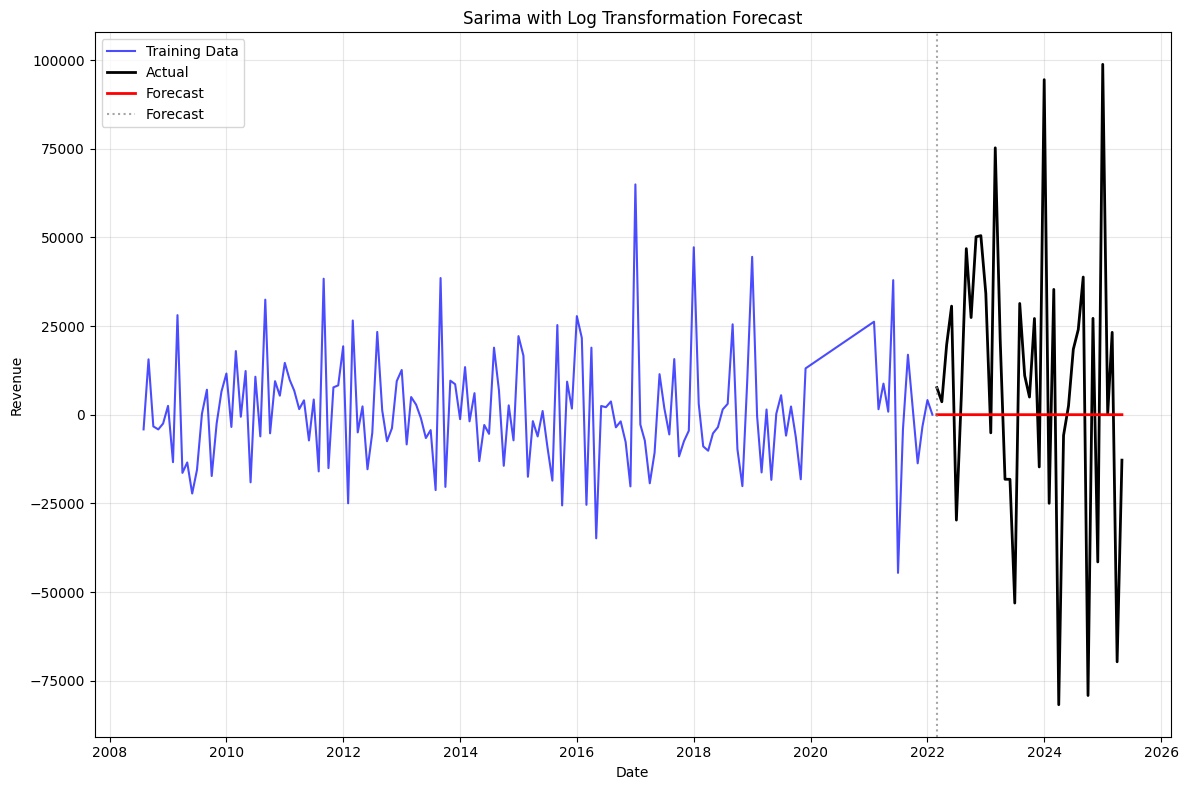


Sarima with Log Transformation Metrics Forecast Accuracy:
MAE:  32423.4281
RMSE: 41504.9563
MASE: 0.6549


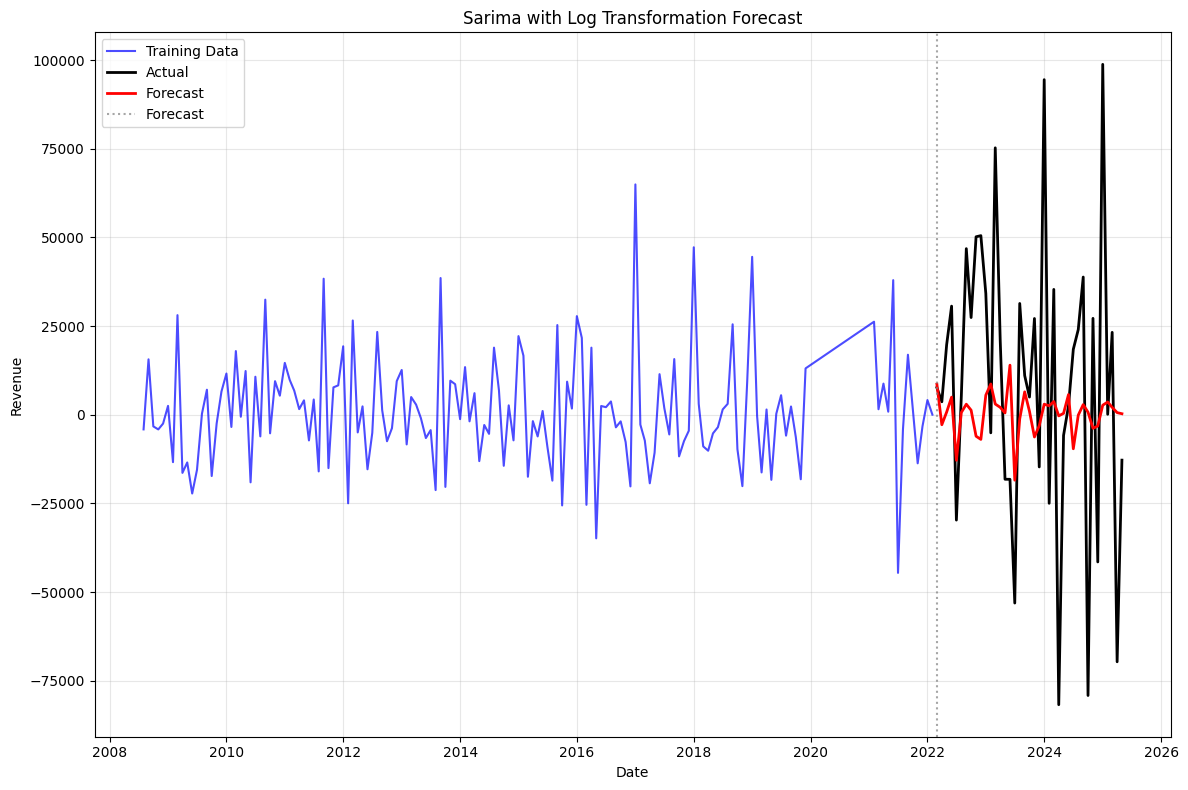


Sarima without Log Transformation Metrics Forecast Accuracy:
MAE:  31941.2874
RMSE: 40842.7369
MASE: 0.6452


In [17]:
def forecast_sarima(model, n_periods):

    forecast = model.predict(n_periods=n_periods)
    
    return forecast

def plot_forecast (train_series, test_series, prediction, title):
    plt.figure(figsize= (12,8))
    plt.plot(train_series.index, train_series.values, 
            label='Training Data', color='blue', alpha=0.7)
    
    # Plot actual test data
    plt.plot(test_series.index, test_series.values, 
            label='Actual', color='black', linewidth=2)
    
    # Plot predictions
    plt.plot(test_series.index, prediction.values, 
            label='Forecast', color='red', linewidth=2)
    
    plt.axvline(x = test_series.index[0], color='gray', 
               linestyle=':', alpha=0.7, label='Forecast')
    
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Revenue')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
def evaluate_forecast(actual, predicted, model_name="Model"):
    """Calculate common forecast accuracy metrics"""
    from sklearn.metrics import mean_absolute_error, mean_squared_error
    import numpy as np
    
    # Remove any NaN values
    mask = ~(np.isnan(actual) | np.isnan(predicted))
    actual_clean = actual[mask]
    predicted_clean = predicted[mask]
    
    # Calculate metrics
    mae = mean_absolute_error(actual_clean, predicted_clean)
    rmse = np.sqrt(mean_squared_error(actual_clean, predicted_clean))
    mape = np.mean(np.abs((actual_clean - predicted_clean) / actual_clean)) * 100
    
    # Mean Absolute Scaled Error (MASE) - if you have naive forecast
    naive_error = np.mean(np.abs(np.diff(actual_clean)))
    mase = mae / naive_error if naive_error != 0 else np.inf
    
    print(f"\n{model_name} Forecast Accuracy:")
    print(f"{'='*40}")
    print(f"MAE:  {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MASE: {mase:.4f}")
    
    return {
        'mae': mae,
        'rmse': rmse,
        'mase': mase
    }

period = len(test_revenue)
first_model_prediction = forecast_sarima(model=sarima_model_log, n_periods=period)
plot_forecast (train_revenue, test_revenue, first_model_prediction, 'Sarima with Log Transformation Forecast')
forecast_metrics = evaluate_forecast(test_revenue, first_model_prediction, "Sarima with Log Transformation Metrics")

second_model_prediction = forecast_sarima(model=sarima_model, n_periods=period)
plot_forecast (train_revenue, test_revenue, second_model_prediction, 'Sarima with Log Transformation Forecast')
forecast_metrics = evaluate_forecast(test_revenue, second_model_prediction, "Sarima without Log Transformation Metrics")


Even though the SARIMA model trained with Log transformed Room Revenue has lower AIC , its forecast accuracy is low with higher Mean Absolute Error (MAE), Root Mean Squared Error (RMSE) and Mean Absolute Scaled Error (MASE). The SARIMA model without Log transformation performs better even with a higher AIC. Log transforms improve the fit of the model but harms forecast utility due to over-smoothing which oversimplify the trends, leading to the flat forecast as seen. 